## 任务一：基于机器学习的文本分类
### 2019-07-15 ~ 2019-07-18
实现基于logistic/softmax regression的文本分类<br>

#### 参考

文本分类<br>
《神经网络与深度学习》 第2/3章<br>
#### 数据集：Classify the sentiment of sentences from the Rotten Tomatoes dataset

#### 实现要求：NumPy

#### 需要了解的知识点：

文本特征表示：Bag-of-Word，N-gram<br>
分类器：logistic/softmax regression，损失函数、（随机）梯度下降、特征选择<br>
数据集：训练集/验证集/测试集的划分<br>
#### 实验：

分析不同的特征、损失函数、学习率对最终分类性能的影响<br>
shuffle 、batch、mini-batch<br>
#### 时间：两周

### 1. 文本特征表示

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re, string
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
# 数据读取
df_train = pd.read_csv("data_task1/train.tsv", sep="\t")
df_test = pd.read_csv("data_task1/test.tsv", sep="\t")

In [4]:
# 数据清洗
def to_lowercase(words):
    """ 转换为小写 """
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """ 去除标点符号 """
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """ 去除数字 """
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """ 去除停用词 """
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """ 词形还原 """
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def preprocess(words):
    """ 封装以上操作 """
    #words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    #words = lemmatize_verbs(words)
    return words

#### 文本向量化

In [5]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
# 1.分词
df_train['Words'] = df_train['Phrase'].apply(nltk.word_tokenize)


# 2.预处理
df_train['Words'] = df_train['Words'].apply(preprocess) 
df_train['Words'].head()


0    [series, escapades, demonstrating, adage, good...
1    [series, escapades, demonstrating, adage, good...
2                                             [series]
3                                                   []
4                                             [series]
Name: Words, dtype: object

In [6]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Words
0,1,1,A series of escapades demonstrating the adage ...,1,"[series, escapades, demonstrating, adage, good..."
1,2,1,A series of escapades demonstrating the adage ...,2,"[series, escapades, demonstrating, adage, good..."
2,3,1,A series,2,[series]
3,4,1,A,2,[]
4,5,1,series,2,[series]


In [34]:
# # 3.构建词表
# word_set = set()
# for l in df_train['Words']:
#     for e in l:
#         if e != "":
#             word_set.add(e)
# 3.构建词典
word_set = set()
word_dict = {}
for l in df_train['Words']:
    for e in l:
        if e != "":
            if e not in word_dict:
                word_dict[e] = 1
            else:
                word_dict[e] += 1

# 词表维数过高，只选择频数>1000的词作为特征                
for k, v in word_dict.items():
    if v > 500:
        word_set.add(k)
    
print(word_set)
        
# 4.将词项映射到ID        
word_to_int = {word: i for i, word in enumerate(word_set, 1)}
def get_tokens(l):
    l_new = []
    for word in l:
        if word in word_to_int:
            l_new.append(word_to_int[word])
        else:
            l_new.append('unk')
    return l_new
#df_train['Tokens'] = df_train['Words'].apply(lambda l: [word_to_int[word] for word in l])
df_train['Tokens'] = df_train['Words'].apply(get_tokens)
#print(df_train['Tokens'].head())
#print(df_train.head())

                                                
# 5.求最长Phrases所包含的词项，其他末尾添0
max_len = df_train['Tokens'].str.len().max()
print(max_len)

# all_tokens = np.array([t for t in df_train['Tokens']])
# encoded_labels = np.array([l for l in df_train['Sentiment']])

# features = np.zeros((len(all_tokens), max_len), dtype=int)
# for i, row in enumerate(all_tokens):
#     features[i, :len(row)] = row


# print(features[:5])

{'watching', 'without', 'human', 'never', 'nothing', 'times', 'scenes', 'years', 'young', 'almost', 'moments', 'watch', 'dialogue', 'rrb', 'also', 'comes', 'good', 'kind', 'old', 'tale', 'could', 'story', 'movie', 'hard', 'quite', 'take', 'may', 'best', 'right', 'audience', 'script', 'rather', 'lot', 'cinema', 'yet', 'world', 'emotional', 'seems', 'performances', 'work', 'nt', 'humor', 'like', 'romantic', 'bad', 'screen', 'sense', 'subject', 'fun', 'interesting', 'even', 'thriller', 'movies', 'little', 'end', 'something', 'ever', 'heart', 'still', 'plot', 'new', 'documentary', 'look', 'well', 'far', 'makes', 'love', 'man', 'people', 'way', 'enough', 'entertaining', 'back', 'great', 'comedy', 'full', 'two', 'american', 'might', 'much', 'life', 'picture', 'get', 'acting', 'thing', 'material', 'another', 'lrb', 'less', 'hollywood', 'funny', 'action', 'time', 'long', 'first', 'find', 'see', 'often', 'make', 'film', 'performance', 'actors', 'really', 'year', 'going', 'come', 'would', 'bette

In [35]:
# 重复采样
sent_2 = df_train[df_train['Sentiment']==2]
#we will copy class 0 11 times
sent_0 = df_train[df_train['Sentiment']==0]
#we will copy class 1 2 times
sent_1 = df_train[df_train['Sentiment']==1]
#we will copy class 3 2 times
sent_3 = df_train[df_train['Sentiment']==3]
#we will copy class 4 8 times
sent_4 = df_train[df_train['Sentiment']==4]

#-----------------------------------------------------
df_train1 = df_train.append([sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0])
df_train1 = df_train.append([sent_1])
df_train1 = df_train.append([sent_3])
df_train1 = df_train.append([sent_4,sent_4,sent_4,sent_4,sent_4,sent_4,sent_4])

In [37]:
all_tokens = np.array([t for t in df_train1['Tokens']])
encoded_labels = np.array([l for l in df_train1['Sentiment']])

print(all_tokens)
embed = np.zeros((len(all_tokens), len(word_set)), dtype = int)
for i, row in enumerate(all_tokens):
    for x in row:
        if x != 'unk':
            embed[i, x-1] += 1


[list(['unk', 'unk', 'unk', 'unk', 17, 'unk', 15, 17, 'unk', 'unk', 'unk', 'unk', 'unk', 80, 22])
 list(['unk', 'unk', 'unk', 'unk', 17, 'unk']) list(['unk']) ...
 list(['unk', 'unk'])
 list([103, 74, 'unk', 'unk', 124, 37, 'unk', 'unk', 'unk'])
 list([74, 'unk', 'unk', 124, 37, 'unk', 'unk', 'unk'])]


#### 训练 & 验证集划分

In [38]:
# split_frac = 0.8

# split_idx = int(len(features)*0.8)

# train_x, test_x = embed[:split_idx], embed[split_idx:]
# train_y, test_y = encoded_labels[:split_idx], encoded_labels[split_idx:]
train_x, test_x, train_y, test_y = train_test_split(embed, encoded_labels, test_size=0.3, random_state = 0, shuffle = True)
 

## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(154351, 130) 
Test set: 		(66151, 130)


### 2. 查看维度 & 预处理

In [39]:
m_train = len(train_x)
m_test = len(test_x)
num_word = train_x.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Width of each example: num_word = " + str(num_word))
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: m_train = 154351
Number of testing examples: m_test = 66151
Width of each example: num_word = 130
train_x shape: (154351, 130)
train_y shape: (154351,)
test_x shape: (66151, 130)
test_y shape: (66151,)


In [40]:
# 把labels转成one-hot格式
def convert_to_onehot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [41]:
train_x_transpose = train_x.T
test_x_transpose = test_x.T

train_y_onehot = convert_to_onehot(train_y, 5)
test_y_onehot = convert_to_onehot(test_y, 5)

print ("train_x_flatten shape: ",train_x_transpose.shape)
print ("train_y_onehot shape: " ,train_y_onehot.shape)
print ("test_x_flatten shape: " ,test_x_transpose.shape)
print ("test_y_onehot shape: ",test_y_onehot.shape)

train_x_flatten shape:  (130, 154351)
train_y_onehot shape:  (5, 154351)
test_x_flatten shape:  (130, 66151)
test_y_onehot shape:  (5, 66151)


### 3. 分类器

模型架构及参数选择：
1. 模型框架：input layer — hidden layer (128 units, relu） — output layer(5 units, softmax)
2. 激活函数：relu和softmax
3. 参数初始化方式：随机初始化
4. 损失函数：softmax交叉熵
5. 优化算法：梯度下降

#### 激活函数 ReLU & softMax

In [42]:
def relu(Z):
    """
    ReLU函数
    Z -- 线性输出
    """
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [43]:
# exp(z)容易造成数值上溢
# 可以证明softmax(z) = soft(z+c),其中c为常数，即softmax对input加减一个常数项具有不变性。
# 因此，z = z - max(z)
def softmax(Z):
    """
    softmax函数
    """
    Z_shift = Z - np.max(Z, axis = 0)
    A = np.exp(Z_shift) / np.sum(np.exp(Z_shift), axis=0)
    
    cache = Z_shift
    
    return A, cache

In [44]:
def sigmoid(Z):
    """
    Sigmoid函数
    """
    A = 1.0 / (1 + np.exp(-Z))
    
    cache = Z
    
    return A, cache

#### 参数随机初始化

In [45]:
def initialize_parameters(n_x, n_h, n_y):
    """
    参数:
    n_x -- 输入层大小
    n_h -- 隐藏层大小
    n_y -- 输出层大小
    
    返回：
    W1 -- 权重矩阵，(n_h, n_x)
    b1 -- 偏置向量，(n_h, 1)
    W2 -- 权重矩阵 (n_y, n_h)
    b2 -- 偏置向量 (n_y, 1)
    """
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01   
    b1 = np.zeros((n_h, 1))                 
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters    

#### 前向传播


线性部分：$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$


where $A^{[0]} = X$. 

In [46]:
def linear_forward(A, W, b):
    """
    前向传播--线性部分,加权求和

    Arguments:
    A -- 当前输入
    W -- 权重矩阵
    b -- 偏置
    """
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

非线性部分：  $$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$$ <br>
   "g" -- softmax() or relu().

In [47]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    前向传播--非线性部分，经过激活函数
    """
    
    if activation == "softmax":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
      
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

#### 损失函数

In [48]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- 预测概率
    Y -- 真实标记

    Returns:
    cost -- 交叉熵损失
    """
    m = Y.shape[1]
    cost = -(np.sum(Y * np.log(AL))) / float(m)
    #cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

#### 反向传播

In [49]:
def linear_backward(dZ, cache):
    """
    线性偏导
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / float(m)
    db = np.sum(dZ, axis=1, keepdims=True) / float(m)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [50]:
def relu_backward(dA, cache):
    """
    relu偏导
    """
    Z = cache
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [51]:
def softmax_backward(Y, cache):
    """
    链式法则dL/dZ = （dL/dA） * （dA/dZ）
    """
    Z = cache  #Z_shift
    
    s = np.exp(Z)/ np.sum(np.exp(Z), axis=0)
    dZ = s - Y
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [52]:
def linear_activation_backward(dA, cache, activation):
    """
    激活函数偏导
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
 
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

#### 更新参数

In [53]:
def update_parameters(parameters, grads, learning_rate):

    """
    利用梯度更新参数
    """ 
    L = len(parameters) // 2 # 每层参数个数

    for l in range(1, L + 1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    
    return parameters

#### 总体模型

In [54]:
def model(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 1000, print_cost=False):
    """
    两层神经网络
    返回权重和偏置
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              
    m = X.shape[1]                          
    (n_x, n_h, n_y) = layers_dims
    
    # 参数初始化
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # 迭代
    for i in range(0, num_iterations):
        # mini-batch
#         start = (i * batch_size) % m
#         end = min(start + batch_size , m)

#         X_p = X[:, start: end]
#         Y_p = Y[:, start: end]
        # 前向传播
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='softmax')

        # 计算损失
        cost = compute_cost(A2, Y)
        
        # 误差反向传播
        dA1, dW2, db2 = linear_activation_backward(Y, cache2, activation='softmax')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # 更新参数
        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # 输出损失
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # 画图

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations(* 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [68]:
print(train_x_transpose.shape)
train_data_x = train_x_transpose
train_data_y = train_y_onehot

(130, 154351)


### 4. 训练模型获取参数

Cost after iteration 0: 1.6094781967375478
Cost after iteration 100: 1.4022126005080553
Cost after iteration 200: 1.3896550868164732
Cost after iteration 300: 1.386052053257626
Cost after iteration 400: 1.3838850140183125
Cost after iteration 500: 1.3814843803972054
Cost after iteration 600: 1.3779390462871317
Cost after iteration 700: 1.3725400904650225
Cost after iteration 800: 1.3650067393551821
Cost after iteration 900: 1.3559298427518331
Cost after iteration 1000: 1.3465672595826004
Cost after iteration 1100: 1.3379609383216826
Cost after iteration 1200: 1.3304378235842458
Cost after iteration 1300: 1.3239498903952511
Cost after iteration 1400: 1.3184555645575742
Cost after iteration 1500: 1.3138959624457036
Cost after iteration 1600: 1.3101919545569056
Cost after iteration 1700: 1.3072201777624672
Cost after iteration 1800: 1.3048537755324616
Cost after iteration 1900: 1.3029566468438458
Cost after iteration 2000: 1.3014147330447516
Cost after iteration 2100: 1.300132584793912
Co

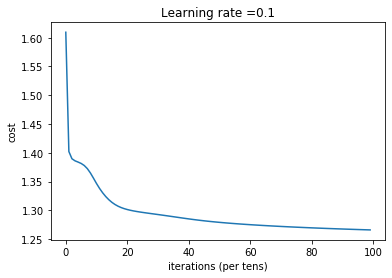

In [69]:
parameters = model(train_data_x, train_data_y, layers_dims = (130, 128, 5), learning_rate = 0.1,
                             num_iterations = 10000, print_cost=True)


In [73]:
def predict_labels(X, y, parameters):
    """
    预测类别，计算精度
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Forward propagation
    A1, _ = linear_activation_forward(X, W1, b1, activation='relu')
    probs, _ = linear_activation_forward(A1, W2, b2, activation='softmax')
    
    # convert probas to 0-4 predictions
    predict_label = np.argmax(probs, axis=0)
#     for i in predict_label:
#         if i != 2:
#             print(i)
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((predict_label == y)/float(m))))
        
    return predict_label

In [74]:
# parameters = initialize_parameters(50, 128, 5)
prediction = predict_labels(test_x_transpose, test_y, parameters)

Accuracy: 0.4976493174706354


#### 真实测试数据 & 结果输出

In [75]:
def predict_labels_without_y(X, parameters):
    """
    对无标记数据预测类别
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Forward propagation
    A1, _ = linear_activation_forward(X, W1, b1, activation='relu')
    probs, _ = linear_activation_forward(A1, W2, b2, activation='softmax')
    
    # convert probas to 0-4 predictions
    predict_label = np.argmax(probs, axis=0)
    for i in predict_label:
        if i != 2:
            print(i)
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    #print("Accuracy: "  + str(np.sum((predict_label == y)/float(m))))
        
    return predict_label

In [63]:
## 测试集
from numpy import savetxt
df_test['Words'] = df_test['Phrase'].apply(nltk.word_tokenize)

df_test['Words'] = df_test['Words'].apply(normalize) 
df_test['Words'].head()

df_test['Tokens'] = df_train['Words'].apply(get_tokens)


test_tokens = np.array([t for t in df_test['Tokens']])

test_embed = np.zeros((len(test_tokens), len(word_set)), dtype = int)

for i, row in enumerate(test_tokens):
    for x in row:
        if x != 'unk':
            embed[i, x-1] += 1

df_test_x = test_embed.T



In [76]:
predicted = predict_labels_without_y(df_test_x, parameters)
pred = [[index + 156061,x] for index, x in enumerate(predicted)]
savetxt('zzmsampleSubmission.csv',pred,delimiter=',',fmt='%d,%d',header='PhraseId,Sentiment',comments='')